# Transfer Learning com o Modelo Pré-Treinado MobileNetV2

### Passo 1
Instalação das bibliotecas necessárias e definição dos caminhos para os dados obtidos do dataset público MPIIGaze.

In [1]:
# Instala as bibliotecas de visualização de dados no kernel do Notebook
%pip install ipywidgets tqdm

# Imports
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm # barra de progresso durante o carregamento de dados

# Importações do Keras/TensorFlow
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence

# Importa separação de dados de treinamento e teste
from sklearn.model_selection import train_test_split

# Definir tamanho de imagem para MobileNetV2 (padrão)
IMAGE_SIZE = 224

PROJECT_ROOT = os.path.dirname(os.getcwd())
# Caminho para a pasta de dados
MPIIGAZE_ROOT = os.path.join(PROJECT_ROOT, 'data', 'MPIIGaze')
DATA_PATH = os.path.join(MPIIGAZE_ROOT, 'Data', 'Original')

print(f"Caminho Base dos Dados: {DATA_PATH}")

Note: you may need to restart the kernel to use updated packages.
Caminho Base dos Dados: c:\Mackenzie\2025.2\EyeTracker\data\MPIIGaze\Data\Original


### Passo 2
Extrair dados utlizados para treinamento (imagem,gaze_x,gaze_y) dos dados brutos armazenados no dataset MPIIGaze (15 participantes). Criar dataframe, remover dados inválidos, normalizar dados e separa dados de treino e teste.

In [2]:
data_list = []
# Iterar sobre as pastas dos participantes (p00 a p14)
for participant_id in sorted(os.listdir(DATA_PATH)):
    participant_path = os.path.join(DATA_PATH, participant_id)

    # Analisar cada participante
    if os.path.isdir(participant_path):

        # Analisar todos os dias para um participante
        for day_folder in os.listdir(participant_path):
            day_path = os.path.join(participant_path, day_folder)
            annotation_file = os.path.join(day_path, 'annotation.txt')
            
            # No arquivo de dados numéricos e caminho da imagem
            if os.path.exists(annotation_file):
                try:
                    # Ler aquivo annotations como csv (string)
                    annotations = pd.read_csv(annotation_file, sep=' ', header=None, dtype={0: str})
                    
                    # Pegar cada linha e analisar dados
                    for index, row in annotations.iterrows():
                        image_id_base = str(row[0]).strip()
                        
                        # Formatar ID com zeros à esquerda e adicionar extensão .jpg
                        if image_id_base and image_id_base.isdigit():
                            formatted_id = image_id_base.zfill(4) 
                            full_image_name = formatted_id + '.jpg'
                        else:
                            continue # Pular arquivos inválidos
                        
                        # Posição alvo do olhar na tela (x, y) no arquivo annotations
                        gaze_x = row[24]
                        gaze_y = row[25]
                        
                        image_path = os.path.join(day_path, full_image_name)
                        
                        # Armazena dados na lista
                        data_list.append({
                            'image_path': image_path,
                            'gaze_x': gaze_x,
                            'gaze_y': gaze_y
                        })
                
                except Exception as e:
                    continue

# Criar dataframe
df = pd.DataFrame(data_list)
print(f"Total de amostras carregadas inicialmente: {len(df)}")

# Transformar colunas de coordenadas do olhar em atributos numéricos
df['gaze_x'] = pd.to_numeric(df['gaze_x'], errors='coerce')
df['gaze_y'] = pd.to_numeric(df['gaze_y'], errors='coerce')

# Remover linhas inválidas
df_cleaned = df.dropna(subset=['gaze_x', 'gaze_y', 'image_path'])

MAX_SCREEN_X = 1920.0
MAX_SCREEN_Y = 1080.0

# Normalizar as coordenadas de gaze
df_cleaned['gaze_x_norm'] = df_cleaned['gaze_x'] / MAX_SCREEN_X
df_cleaned['gaze_y_norm'] = df_cleaned['gaze_y'] / MAX_SCREEN_Y

# Separar dados de treino e teste
df_train, df_val = train_test_split(df_cleaned, test_size=0.2, random_state=42) 

# Mostrar número de amostras removidas e restantes
amostras_removidas = len(df) - len(df_cleaned)
print(f"Amostras removidas (NaNs/Inválidas): {amostras_removidas}")
print(f"Total de amostras válidas restantes: {len(df_cleaned)}")

Total de amostras carregadas inicialmente: 213658
Amostras removidas (NaNs/Inválidas): 0
Total de amostras válidas restantes: 213658


### Passo 3
Divisão do conjunto de treinamento e conjunto de teste em batches.

In [4]:
class GazeDataGenerator(Sequence):
    
    def __init__(self, df, batch_size, image_size=224, shuffle=True, **kwargs):

        super().__init__(**kwargs)
        
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        # Gera um único batch de dados
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        X_batch = []
        Y_batch = []
        
        # Carregar dados do batch do disco
        for i in batch_indices:
            row = self.df.iloc[i]
            
            # Carregar imagem com OpenCV
            img = cv2.imread(row['image_path'])
            
            if img is not None:
                # Pré-processamento: Redimensionar e Normalizar
                img_resized = cv2.resize(img, (self.image_size, self.image_size))
                img_normalized = img_resized / 255.0
                
                X_batch.append(img_normalized)
                
                # Coordenadas x e y
                Y_batch.append([row['gaze_x_norm'], row['gaze_y_norm']])
        
        # Retorna os tensores do batch
        return np.array(X_batch, dtype=np.float32), np.array(Y_batch, dtype=np.float32)

    def on_epoch_end(self):
        # Embaralha os índices no final de cada epoch
        if self.shuffle == True:
            np.random.shuffle(self.indices)

BATCH_SIZE = 64 # Tamanho do batch
IMAGE_SIZE = 224

# Separação dos batches para conjunto de treinamento e teste
train_generator = GazeDataGenerator(df=df_train, batch_size=BATCH_SIZE, shuffle=True)
validation_generator = GazeDataGenerator(df=df_val, batch_size=BATCH_SIZE, shuffle=False)

### Passo 4
Usar modelo pre-treinado MobileNetV2 excluindo camada de classificação do modelo, atribuir camadas do modelo, função de perda e treinamento do modelo.

In [ ]:
# Definir o tamanho de imagem para ResNet-50 (padrão)
IMAGE_SIZE = 224

# Carregar a base MobileNetV2
input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

base_model = MobileNetV2(
    input_tensor=input_tensor,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    weights='imagenet',
    include_top=False  # Remove a camada de classificação original
)

# Congelar as camadas iniciais (Transfer Learning)
for layer in base_model.layers:
    layer.trainable = False

# Adicionar o 'Head' de Regressão
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduz as dimensões para um vetor
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# Camada de saída: 2 neurônios (gaze_x_norm, gaze_y_norm)
predictions = Dense(2, activation='linear')(x) 

# Criar o Modelo Final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar com função de perda mse (Erro Quadrático Médio), função de métricas (histórico) mae (Erro Absoluto Médio)
# e otimizador Adam(com taxa de aprendizado lenta)
model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='mse',
    metrics=['mae'] 
)

### Passo 5
Treinamento do modelo, salvando o melhor conjunto de parâmetros obtido durante o treinamento.

In [6]:
# Obter pasta de modelos
PROJECT_ROOT = os.path.dirname(os.getcwd())
models_dir = os.path.join(PROJECT_ROOT, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Pegar a pasta para salvar o modelo treinado
checkpoint_filepath = os.path.join(models_dir, 'mobilenet_gaze_tl_best.h5')

# Salvar o melhor modelo mesmo que o treinamento piore (Overfitting)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss', 
    mode='min'
)

# Treinamento do modelo
print("Iniciando treinamento...")
history = model.fit(
    train_generator,
    epochs=10, # 5 épocas
    validation_data=validation_generator,
    callbacks=[model_checkpoint_callback]
)

print(f"\nTreinamento concluído. O melhor modelo foi salvo em: {checkpoint_filepath}")

Iniciando treinamento...
Epoch 1/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.0618 - mae: 0.2037

2670/2670 ━━━━━━━━━━━━━━━━━━━━ 801s 299ms/step - loss: 0.0529 - mae: 0.1941 - val_loss: 0.0493 - val_mae: 0.1896
Epoch 2/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 616s 231ms/step - loss: 0.0486 - mae: 0.1885 - val_loss: 0.0508 - val_mae: 0.1914
Epoch 3/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0477 - mae: 0.1871

2670/2670 ━━━━━━━━━━━━━━━━━━━━ 619s 232ms/step - loss: 0.0478 - mae: 0.1873 - val_loss: 0.0483 - val_mae: 0.1882
Epoch 4/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0475 - mae: 0.1868

2670/2670 ━━━━━━━━━━━━━━━━━━━━ 620s 232ms/step - loss: 0.0475 - mae: 0.1868 - val_loss: 0.0481 - val_mae: 0.1879
Epoch 5/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 0.0472 - mae: 0.1862

2670/2670 ━━━━━━━━━━━━━━━━━━━━ 638s 239ms/step - loss: 0.0472 - mae: 0.1862 - val_loss: 0.0474 - val_mae: 0.1868
Epoch 6/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 651s 244ms/step - loss: 0.0470 - mae: 0.1858 - val_loss: 0.0474 - val_mae: 0.1868
Epoch 7/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - loss: 0.0470 - mae: 0.1856

2670/2670 ━━━━━━━━━━━━━━━━━━━━ 653s 245ms/step - loss: 0.0469 - mae: 0.1854 - val_loss: 0.0472 - val_mae: 0.1863
Epoch 8/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.0466 - mae: 0.1848

2670/2670 ━━━━━━━━━━━━━━━━━━━━ 661s 248ms/step - loss: 0.0467 - mae: 0.1850 - val_loss: 0.0472 - val_mae: 0.1862
Epoch 9/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.0464 - mae: 0.1844

2670/2670 ━━━━━━━━━━━━━━━━━━━━ 648s 243ms/step - loss: 0.0465 - mae: 0.1846 - val_loss: 0.0470 - val_mae: 0.1859
Epoch 10/10
2670/2670 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 0.0464 - mae: 0.1841

2670/2670 ━━━━━━━━━━━━━━━━━━━━ 651s 244ms/step - loss: 0.0464 - mae: 0.1843 - val_loss: 0.0470 - val_mae: 0.1856

Treinamento concluído. O melhor modelo foi salvo em: c:\Mackenzie\2025.2\EyeTracker\models\mobilenet_gaze_tl_best.h5


### Passo 6
Gráfico de métricas.

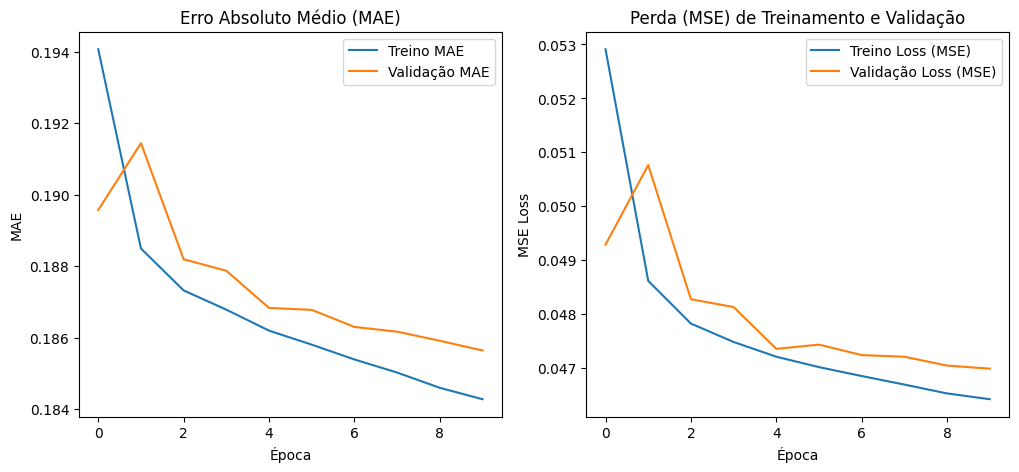

In [7]:
import matplotlib.pyplot as plt
import numpy as np

hist = history.history

mae = hist['mae']
val_mae = hist['val_mae']

loss = hist['loss']
val_loss = hist['val_loss']

epochs_range = range(len(history.history['mae']))

plt.figure(figsize=(12, 5))

# Gráfico 1: Métrica MAE
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Treino MAE')
plt.plot(epochs_range, val_mae, label='Validação MAE')
plt.legend(loc='upper right') 
plt.title('Erro Absoluto Médio (MAE)')
plt.xlabel('Época')
plt.ylabel('MAE')


# Gráfico 2: Perda MSE
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Treino Loss (MSE)')
plt.plot(epochs_range, val_loss, label='Validação Loss (MSE)')
plt.legend(loc='upper right')
plt.title('Perda (MSE) de Treinamento e Validação')
plt.xlabel('Época')
plt.ylabel('MSE Loss')

plt.show()